In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=5882ceabd98073f2c4775c13448e88913d64b1f3f622f053caf10066ef68ed96
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
!git clone https://github.com/Pradeep-Kumar-Rebbavarapu/EMG_data

Cloning into 'EMG_data'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 4), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 5.58 KiB | 1.39 MiB/s, done.


In [3]:
!pip install tensorflow_addons

In [4]:
!pip install keras-lookahead

  Preparing metadata (setup.py) ... done
  Created wheel for keras-lookahead: filename=keras_lookahead-0.9.0-py3-none-any.whl size=6386 sha256=324f7ef5146c3e8daf16396d877501ce809e7d415b0182bd584bdac128b5a338
  Stored in directory: /root/.cache/pip/wheels/f0/87/b1/07761aa9c1570e0cf31245fa80739d2c606b3f930d269dcade
Successfully built keras-lookahead


In [5]:
import os
import wget

In [6]:
bc_dict = {
    2: {
        0:0,
        1:1,
        2:2,
        3:3,
        4:4,
        5:5,
        6:6,
        7:7,
        8:8,
        9:9,
       10:10,
       11:11,
       12:12,
       13:13,
       14:14,
       15:15,
       16:16,
       17:17,
    },
    3: {
        0:0,
        1:18,
        2:19,
        3:20,
        4:21,
        5:22,
        6:23,
        7:24,
        8:25,
        9:26,
       10:27,
       11:28,
       12:29,
       13:30,
       14:31,
       15:32,
       16:33,
       17:34,
       18:35,
       19:36,
       20:37,
       21:38,
       22:39,
       23:40,
    }
}


In [7]:
label_dict = {
    1: {
        0:0,
        1:1,
        2:2,
        3:3,
        4:4,
        5:5,
        6:6,
        7:7,
        8:8,
        9:9,
        10:10,
        11:11,
        12:12
    },
    2: {
        0:0,
        1:13,
        2:14,
        3:15,
        4:16,
        5:17,
        6:18,
        7:19,
        8:20,
        9:21,
        10:22,
        11:23,
        12:24,
        13:25,
        14:26,
        15:27,
        16:28,
        17:29,
    },
    3: {
        0:0,
        1:30,
        2:31,
        3:32,
        4:33,
        5:34,
        6:35,
        7:36,
        8:37,
        9:38,
        10:39,
        11:40,
        12:41,
        13:42,
        14:43,
        15:44,
        16:45,
        17:46,
        18:47,
        19:48,
        20:49,
        21:50,
        22:51,
        23:52,
    }
}


In [8]:
import random
import multiprocessing
import numpy as np
import pandas as pd
from scipy import signal
from scipy.io import loadmat



def roll_labels(x, y):
    labs_rolled = []
    for i in range(len(y)):
        l = y[i]
        n = x[i].shape[0]
        labs_rolled.append(np.repeat(l, n))
    return np.hstack(labs_rolled)


def window_roll(a, stepsize=5, width=52):
    n = a.shape[0]
    emg = np.dstack([a[i : 1 + n + i - width : stepsize] for i in range(0, width)])
    return emg


def add_noise_snr(signal, snr=25):
    sgn_db = np.log10((signal ** 2).mean(axis=0)) * 10
    noise_avg_db = sgn_db - snr
    noise_variance = 10 ** (noise_avg_db / 10)
    noise = np.random.normal(0, np.sqrt(noise_variance), signal.shape)
    return signal + noise

rlist = sum([[(x / 2) % 30] * ((x // 2) % 30) for x in range(120)], [])


def add_noise_random(signal):
    num = random.choice(rlist)
    return add_noise_snr(signal, num)



def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode="valid")


def ma(window, n):
    return np.vstack(
        [moving_average(window[:, i], n) for i in range(window.shape[-1])]
    ).T


def ma_batch(batch, n):
    return np.dstack([ma(batch[i, :, :], n) for i in range(batch.shape[0])])



def _butter_highpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype="high", analog=False)
    return b, a


def butter_highpass_filter(data, cutoff=2, fs=200, order=3):
    b, a = _butter_highpass(cutoff=cutoff, fs=fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



def first0(x):
    return np.unique(x)[0]


def first_appearance(arr):

    inn = [arr[i] for i in range(arr.shape[0])]
    with multiprocessing.Pool(None) as p:
        res = p.map(first0, inn)
    return np.asarray(res)


class dataset(object):
    def __init__(
        self,
        path,
        butter=True,
        rectify=True,
        ma=15,
        step=5,
        window=52,
        exercises=["a", "b", "c"],
        features=None,
    ):
        self.path = path
        self.butter = butter
        self.rectify = rectify
        self.ma = ma
        self.step = step
        self.window = window
        self.exercises = exercises
        self.features = features


        self.read_data()
        self.process_data()

    def _load_file(self, path, ex, features=None):
        res = loadmat(path)
        data = []
        imu = res["acc"].copy()
        rep = res["rerepetition"].copy()
        emg = res["emg"].copy()
        lab = res["restimulus"].copy()
        if 'a' not in self.exercises:
            lab = np.array([[bc_dict[ex][lab[i][0]]] for i in range(lab.shape[0])])
        else:
            lab = np.array([[label_dict[ex][lab[i][0]]] for i in range(lab.shape[0])])

        del res

        data.append(emg)
        if features:
            for ft in features:
                print("adding features")
                sameDim = data[0].shape[0] == np.shape(res[ft])[0]
                newData = []
                if not sameDim and np.shape(res[ft])[1] == 1:
                    newData = np.full((np.shape(data[0])[0], 1), res[ft][0, 0])
                else:
                    newData = res[ft]
                data.append(newData)

        return np.concatenate(data, axis=1), lab, rep, imu

    def _load_by_trial(self, trial=1, features=None):
        data = []
        labs = []
        reps = []
        imu = []
        for i in range(1, 11):
            path = f"{self.path}/s{i}/S{i}_E{trial}_A1.mat"
            emg, l, r, ii = self._load_file(path, ex=trial, features=features)
            data.append(emg)
            labs.append(l)
            reps.append(r)
            imu.append(ii)
        return data, labs, reps, imu

    def read_data(self):
        ex_dict = dict(zip(["a", "b", "c"], range(1, 4)))
        self.emg = []
        self.labels = []
        self.repetition = []
        self.imu = []

        for e in self.exercises:
            exercise = ex_dict[e]
            emg, lab, rep, imu = self._load_by_trial(trial=exercise, features=self.features)
            self.emg += emg
            self.labels += lab
            self.repetition += rep
            self.imu += imu
        print(sum([x.shape[0] for x in self.emg]))

    def process_data(self):
        if self.rectify:
            self.emg = [np.abs(x) for x in self.emg]

        if self.butter:
            self.emg = [butter_highpass_filter(x) for x in self.emg]

        self.flat = [self.emg, self.labels, self.repetition, self.imu]
        self.emg = [window_roll(x, self.step, self.window) for x in self.emg]
        self.imu = [window_roll(x, self.step, self.window) for x in self.imu]
        self.labels = [window_roll(x, self.step, self.window) for x in self.labels]
        self.repetition = [window_roll(x, self.step, self.window) for x in self.repetition]

        self.emg = np.moveaxis(np.concatenate(self.emg, axis=0), 2, 1)
        self.imu = np.moveaxis(np.concatenate(self.imu, axis=0), 2, 1)
        self.labels = np.moveaxis(np.concatenate(self.labels, axis=0), 2, 1)[..., -1]
        self.repetition = np.moveaxis(np.concatenate(self.repetition, axis=0), 2, 1)[..., -1]

        no_leaks = np.array(
            [
                i
                for i in range(self.repetition.shape[0])
                if np.unique(self.repetition[i]).shape[0] == 1
            ]
        )



        self.emg = self.emg[no_leaks, :, :]
        self.imu = self.imu[no_leaks, :, :]
        self.labels = self.labels[no_leaks, :]
        self.repetition = self.repetition[no_leaks, :]
        self.labels = first_appearance(self.labels)
        self.repetition = first_appearance(self.repetition)
        self.emg = self.emg.astype(np.float16)
        self.imu = self.imu.astype(np.float16)

In [9]:
if "ninaPro" not in os.listdir():
    wget.download('https://www.dropbox.com/s/kxrqhqhcz367v77/nina.tar.gz?dl=1', out='.')
    !tar -xzvf nina.tar.gz

data = dataset("./ninaPro")

ninaPro/
ninaPro/s2/
ninaPro/s2/S2_E1_A1.mat
ninaPro/s2/S2_E3_A1.mat
ninaPro/s2/S2_E2_A1.mat
ninaPro/s3.zip
ninaPro/s10.zip
ninaPro/s6/
ninaPro/s6/S6_E1_A1.mat
ninaPro/s6/S6_E2_A1.mat
ninaPro/s6/S6_E3_A1.mat
ninaPro/s4/
ninaPro/s4/S4_E1_A1.mat
ninaPro/s4/S4_E2_A1.mat
ninaPro/s4/S4_E3_A1.mat
ninaPro/s1.zip
ninaPro/s9/
ninaPro/s9/S9_E1_A1.mat
ninaPro/s9/S9_E2_A1.mat
ninaPro/s9/S9_E3_A1.mat
ninaPro/s9.zip
ninaPro/s8/
ninaPro/s8/S8_E3_A1.mat
ninaPro/s8/S8_E2_A1.mat
ninaPro/s8/S8_E1_A1.mat
ninaPro/s1/
ninaPro/s1/S1_E2_A1.mat
ninaPro/s1/S1_E3_A1.mat
ninaPro/s1/S1_E1_A1.mat
ninaPro/s2.zip
ninaPro/s3/
ninaPro/s3/S3_E2_A1.mat
ninaPro/s3/S3_E3_A1.mat
ninaPro/s3/S3_E1_A1.mat
ninaPro/s4.zip
ninaPro/s10/
ninaPro/s10/S10_E2_A1.mat
ninaPro/s10/S10_E1_A1.mat
ninaPro/s10/S10_E3_A1.mat
ninaPro/s7.zip
ninaPro/s5.zip
ninaPro/s6.zip
ninaPro/s8.zip
ninaPro/s5/
ninaPro/s5/S5_E3_A1.mat
ninaPro/s5/S5_E1_A1.mat
ninaPro/s5/S5_E2_A1.mat
ninaPro/s7/
ninaPro/s7/S7_E1_A1.mat
ninaPro/s7/S7_E3_A1.mat
ninaPro/s7/S7_E2_

In [10]:
import tensorflow as tf


class Lookahead(tf.keras.optimizers.Optimizer):

    def __init__(self,
                 optimizer,
                 sync_period: int = 6,
                 slow_step_size = 0.5,
                 name: str = "Lookahead",
                 **kwargs):
        super().__init__(name, **kwargs)

        if isinstance(optimizer, str):
            optimizer = tf.keras.optimizers.get(optimizer)
        if not isinstance(optimizer, tf.keras.optimizers.Optimizer):
            raise TypeError(
                "optimizer is not an object of tf.keras.optimizers.Optimizer")

        self._optimizer = optimizer
        self._initialized = False

    def _create_slots(self, var_list):
        self._optimizer._create_slots(var_list=var_list)
        for var in var_list:
            self.add_slot(var, 'slow')

    def _create_hypers(self):
        self._optimizer._create_hypers()

    def _prepare(self, var_list):
        return self._optimizer._prepare(var_list=var_list)

    def apply_gradients(self, grads_and_vars, name=None):
        self._optimizer._iterations = self.iterations
        return super().apply_gradients(grads_and_vars, name)

    def _init_op(self, var):
        slow_var = self.get_slot(var, 'slow')
        return slow_var.assign(
            tf.where(
                tf.equal(self.iterations,
                         tf.constant(0, dtype=self.iterations.dtype)),
                var,
                slow_var,
            ),
            use_locking=self._use_locking)

    def _look_ahead_op(self, var):
        var_dtype = var.dtype.base_dtype
        slow_var = self.get_slot(var, 'slow')
        local_step = tf.cast(self.iterations + 1, tf.dtypes.int64)
        sync_period = self._get_hyper('sync_period', tf.dtypes.int64)
        slow_step_size = self._get_hyper('slow_step_size', var_dtype)
        step_back = slow_var + slow_step_size * (var - slow_var)
        sync_cond = tf.equal(
            tf.math.floordiv(local_step, sync_period) * sync_period,
            local_step)
        with tf.control_dependencies([step_back]):
            slow_update = slow_var.assign(
                tf.where(
                    sync_cond,
                    step_back,
                    slow_var,
                ),
                use_locking=self._use_locking)
            var_update = var.assign(
                tf.where(
                    sync_cond,
                    step_back,
                    var,
                ),
                use_locking=self._use_locking)
        return tf.group(slow_update, var_update)

    @property
    def weights(self):
        return self._weights + self._optimizer.weights

    def _resource_apply_dense(self, grad, var):
        init_op = self._init_op(var)
        with tf.control_dependencies([init_op]):
            train_op = self._optimizer._resource_apply_dense(grad, var)
            with tf.control_dependencies([train_op]):
                look_ahead_op = self._look_ahead_op(var)
        return tf.group(init_op, train_op, look_ahead_op)

    def _resource_apply_sparse(self, grad, var, indices):
        init_op = self._init_op(var)
        with tf.control_dependencies([init_op]):
            train_op = self._optimizer._resource_apply_sparse(
                grad, var, indices)
            with tf.control_dependencies([train_op]):
                look_ahead_op = self._look_ahead_op(var)
        return tf.group(init_op, train_op, look_ahead_op)

    def get_config(self):
        config = {
            'optimizer': tf.keras.optimizers.serialize(self._optimizer),
            'sync_period': self._serialize_hyperparameter('sync_period'),
            'slow_step_size': self._serialize_hyperparameter('slow_step_size'),
        }
        base_config = super().get_config()
        return {**base_config, **config}

    @property
    def learning_rate(self):
        return self._optimizer._get_hyper('learning_rate')

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        self._optimizer._set_hyper('learning_rate', learning_rate)

    @property
    def lr(self):
        return self.learning_rate

    @lr.setter
    def lr(self, lr):
        self.learning_rate = lr

    @classmethod
    def from_config(cls, config, custom_objects=None):
        optimizer = tf.keras.optimizers.deserialize(
            config.pop('optimizer'),
            custom_objects=custom_objects,
        )
        return cls(optimizer, **config)

In [11]:
def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    inner = tf.keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=beta_1,
            beta_2=beta_2,
            epsilon=epsilon,
            amsgrad=amsgrad,
            name=name + "_Adam",
        )
    optim = Lookahead(inner, sync_period, slow_step_size, name)
    return inner


In [12]:
import numpy as np
from tensorflow.keras.utils import to_categorical, Sequence



class generator(Sequence):
    def __init__(
        self,
        d: dataset,
        repetitions,
        shuffle = True,
        batch_size = 128,
        imu = False,
        augment = True,
        ma = True,
        has_zero = True
    ) -> None:
        self.shuffle = shuffle
        self.augment = augment
        self.ma = ma
        self.ma_len = d.ma
        self.repetitions = repetitions
        self.batch_size = batch_size
        self.imu = imu
        self.has_zero = has_zero
        idxs = np.where(np.isin(d.repetition, np.array(repetitions)))
        self.X = d.emg[idxs].copy()
        if imu:
            self.X = np.concatenate([self.X.copy(), d.imu[idxs].copy()], axis=-1)
        self.y = to_categorical(d.labels[idxs].copy())
        self.on_epoch_end()

    def __len__(self):
        "number of batches per epoch"
        return int(np.floor(self.X.shape[0] / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(self.X.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'generate a single batch'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        out = self.X[indexes,:,:].copy()
        if self.augment:
            for i in range(out.shape[0]):
                if self.has_zero:
                    if self.y[i,0] == 1:
                        out[i,:,:] = out[i,:,:]
                    else:
                        out[i,:,:]=add_noise_random(out[i,:,:])
                else:
                    out[i,:,:] = add_noise_random(out[i,:,:])
        if self.ma:
            out = np.moveaxis(ma_batch(out, self.ma_len), -1, 0)
        return out,  self.y[indexes,:]


In [13]:
from typing import Union, Callable, List

import numpy as np
import tensorflow as tf


Number = Union[
    float,
    int,
    np.float16,
    np.float32,
    np.float64,
    np.int8,
    np.int16,
    np.int32,
    np.int64,
    np.uint8,
    np.uint16,
    np.uint32,
    np.uint64,
]

Initializer = Union[None, dict, str, Callable]
Regularizer = Union[None, dict, str, Callable]
Constraint = Union[None, dict, str, Callable]
Activation = Union[None, str, Callable]

TensorLike = Union[List[Union[Number, list]], tuple, Number, np.ndarray, tf.Tensor]
FloatTensorLike = Union[tf.Tensor, float, np.float16, np.float32, np.float64]
AcceptableDTypes = Union[tf.DType, np.dtype, type, int, str, None]


In [14]:
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras import backend as K

class Mish(Layer):
    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()))

    def compute_output_shape(self, input_shape):
            return input_shape


@tf.function
def sparsemax(logits: TensorLike, axis: int = -1) -> tf.Tensor:
    logits = tf.convert_to_tensor(logits, name="logits")
    shape = logits.get_shape()
    rank = shape.rank
    is_last_axis = (axis == -1) or (axis == rank - 1)

    if is_last_axis:
        output = _compute_2d_sparsemax(logits)
        output.set_shape(shape)
        return output
    rank_op = tf.rank(logits)
    axis_norm = axis % rank
    logits = _swap_axis(logits, axis_norm, tf.math.subtract(rank_op, 1))
    output = _compute_2d_sparsemax(logits)
    output = _swap_axis(output, axis_norm, tf.math.subtract(rank_op, 1))
    output.set_shape(shape)
    return output


def _swap_axis(logits, dim_index, last_index, **kwargs):
    return tf.transpose(
        logits,
        tf.concat(
            [
                tf.range(dim_index),
                [last_index],
                tf.range(dim_index + 1, last_index),
                [dim_index],
            ],
            0,
        ),
        **kwargs,
    )

@tf.function
def _compute_2d_sparsemax(logits):
    shape_op = tf.shape(logits)
    obs = tf.math.reduce_prod(shape_op[:-1])
    dims = shape_op[-1]
    z = tf.reshape(logits, [obs, dims])
    z_sorted, _ = tf.nn.top_k(z, k=dims)
    z_cumsum = tf.math.cumsum(z_sorted, axis=-1)
    k = tf.range(1, tf.cast(dims, logits.dtype) + 1, dtype=logits.dtype)
    z_check = 1 + k * z_sorted > z_cumsum
    k_z = tf.math.reduce_sum(tf.cast(z_check, tf.int32), axis=-1)
    k_z_safe = tf.math.maximum(k_z, 1)
    indices = tf.stack([tf.range(0, obs), tf.reshape(k_z_safe, [-1]) - 1], axis=1)
    tau_sum = tf.gather_nd(z_cumsum, indices)
    tau_z = (tau_sum - 1) / tf.cast(k_z, logits.dtype)
    p = tf.math.maximum(tf.cast(0, logits.dtype), z - tf.expand_dims(tau_z, -1))
    p_safe = tf.where(
        tf.expand_dims(
            tf.math.logical_or(tf.math.equal(k_z, 0), tf.math.is_nan(z_cumsum[:, -1])),
            axis=-1,
        ),
        tf.fill([obs, dims], tf.cast(float("nan"), logits.dtype)),
        p,
    )
    p_safe = tf.reshape(p_safe, shape_op)
    return p_safe


def sparsemax_loss(
    logits: TensorLike,
    sparsemax: TensorLike,
    labels: TensorLike,
    name = None,
) -> tf.Tensor:
    logits = tf.convert_to_tensor(logits, name="logits")
    sparsemax = tf.convert_to_tensor(sparsemax, name="sparsemax")
    labels = tf.convert_to_tensor(labels, name="labels")
    z = logits
    sum_s = tf.where(
        tf.math.logical_or(sparsemax > 0, tf.math.is_nan(sparsemax)),
        sparsemax * (z - 0.5 * sparsemax),
        tf.zeros_like(sparsemax),
    )
    q_part = labels * (0.5 * labels - z)
    q_part_safe = tf.where(
        tf.math.logical_and(tf.math.equal(labels, 0), tf.math.is_inf(z)),
        tf.zeros_like(z),
        q_part,
    )

    return tf.math.reduce_sum(sum_s + q_part_safe, axis=1)


@tf.function
def sparsemax_loss_from_logits(
    y_true:TensorLike, logits_pred:TensorLike
) -> tf.Tensor:
    y_pred = sparsemax(logits_pred)
    loss = sparsemax_loss(logits_pred, y_pred, y_true)
    return loss


class SparsemaxLoss(tf.keras.losses.Loss):
    def __init__(
        self,
        from_logits: bool = True,
        reduction: str = tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
        name: str = "sparsemax_loss",
    ):
        if from_logits is not True:
            raise ValueError("from_logits must be True")

        super().__init__(name=name, reduction=reduction)
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        return sparsemax_loss_from_logits(y_true, y_pred)

    def get_config(self):
        config = {
            "from_logits": self.from_logits,
        }
        base_config = super().get_config()
        return {**base_config, **config}


In [15]:
import os
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K


class OneCycleLR(Callback):
    def __init__(self,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.batch_size = None
        self.samples = None
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        self.epochs = self.params['epochs']
        self.batch_size = self.params['batch_size']
        self.samples = self.params['samples']
        self.steps = self.params['steps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))


class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than o")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]

            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']


        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)


        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)


        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)


        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):

        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs
        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):

        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

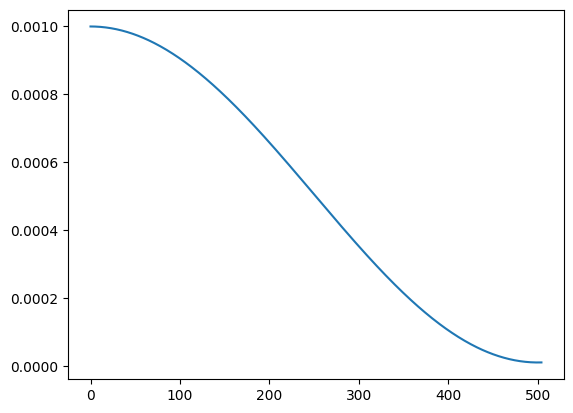

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import math


x = np.arange(505)
mi = 1e-5
ma = 1e-3
gamma = 0.9
rep = 500
t = 500
out = np.zeros(505)
for i in range(x.shape[0]):
    if i>4:
        out[i] = mi + (ma-mi)*(1+math.cos(math.pi*x[i%(rep+5)]/t))/2
    else:
        out[i] = ma
    if out[i] == mi:
        ma *= gamma
plt.plot(out)
plt.show()




In [16]:
import math
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K


class CosineAnnealingScheduler(Callback):
    def __init__(self, T_max, eta_max, eta_min=0, verbose=0, epoch_start=80, restart_epochs=None, gamma=1, expansion=1, flat_end = False):
        super(CosineAnnealingScheduler, self).__init__()
        self.epoch_start=epoch_start
        self.expansion=expansion
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose
        self.restart_epochs = restart_epochs
        self.gamma = gamma
        self.flat_end = flat_end

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'learning_rate'):
            raise ValueError('Optimizer must have a "learning_rate" attribute.')
        if epoch > self.epoch_start - 1:
            if self.restart_epochs is None:
                learning_rate = self.eta_min + (self.eta_max*self.gamma - self.eta_min) * (1 + math.cos(math.pi * (epoch - self.epoch_start) / self.T_max)) / 2
                K.set_value(self.model.optimizer.learning_rate, learning_rate)
            else:
                learning_rate = self.eta_min + (self.eta_max*self.gamma - self.eta_min) * (1 + math.cos(math.pi * ((epoch  % (self.restart_epochs+self.epoch_start)) - self.epoch_start) / self.T_max)) / 2
                K.set_value(self.model.optimizer.learning_rate, learning_rate)
            if learning_rate<=self.eta_min:
                self.eta_max *= self.gamma
                self.T_max *=self.expansion
        if self.flat_end and epoch >= ((self.epoch_start -1 ) + T_max):
            learning_rate = self.eta_min

        else:
            learning_rate=self.model.optimizer.learning_rate
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, learning_rate))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['learning_rate'] = K.get_value(self.model.optimizer.learning_rate)

In [17]:
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import *

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):

        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

In [18]:
class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):

        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than o")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]


            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']


        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)


        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)


        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)


        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
try:
    import tensorflow.keras as keras
    import tensorflow.keras.backend as K
except:
    import keras
    import keras.backend as K
import importlib
import gc


class History(object):
    def __init__(self, history=None):
        if history is not None:
            self.epoch = history.epoch
            self.history = history.history
        else:
            self.epoch = []
            self.history = {}


def concatenate_history(hlist, reindex_epoch=False):
    his = History()

    for h in hlist:
        his.epoch = his.epoch + h.epoch

        for key, value in h.history.items():
            his.history.setdefault(key, [])
            his.history[key] = his.history[key] + value

    if reindex_epoch:
        his.epoch = list(np.arange(0, len(his.epoch)))

    return his


def plot_from_history(history):
    assert isinstance(history, (keras.callbacks.History, History)), "history must be a ``keras.callbacks.History`` or " \
                                                                    "(this module's) ``History`` object. "

    epoch = history.epoch
    val_exist = "val_loss" in history.history

    plt.plot(epoch, history.history["loss"], '.-', label="train")
    if val_exist:
        plt.plot(epoch, history.history["val_loss"], '.-', label="valid")

    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend()


def save_history_to_csv(history, filepath):
    hist = history.history
    hist['epoch'] = history.epoch
    df = pd.DataFrame.from_dict(hist)
    df.to_csv(filepath, index=False)


def reset_keras(per_process_gpu_memory_fraction=1.0):
    sess = K.get_session()
    K.clear_session()
    sess.close()

    gc.collect()


    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = per_process_gpu_memory_fraction
    config.gpu_options.visible_device_list = "0"
    K.set_session(tf.Session(config=config))


def cuda_release_memory():
    spec = importlib.util.find_spec("numba")
    if spec is None:
        raise Exception("numba module cannot be found. Can't function before numba module is installed.")
    else:
        from numba import cuda
    cuda.select_device(0)
    cuda.close()
    return cuda


def moving_window_avg(x, window=5):
    return pd.DataFrame(x).rolling(window=window, min_periods=1).mean().values.squeeze()


def set_momentum(optimizer, mom_val):
    keys = dir(optimizer)
    if "momentum" in keys:
        K.set_value(optimizer.momentum, mom_val)
    if "rho" in keys:
        K.set_value(optimizer.rho, mom_val)
    if "beta_1" in keys:
        K.set_value(optimizer.beta_1, mom_val)


def set_lr(optimizer, lr):
    K.set_value(optimizer.lr, lr)


In [20]:
try:
    import tensorflow.keras as keras
    import tensorflow.keras.backend as K
except:
    import keras
    import keras.backend as K
import numpy as np
import os
import matplotlib.pyplot as plt
class LrRangeTest(keras.callbacks.Callback):
    def __init__(self,
                 lr_range=(1e-5, 10),
                 wd_list=[],
                 steps=100,
                 batches_per_step=5,
                 threshold_multiplier=5,
                 validation_data=None,
                 validation_batch_size=16,
                 batches_per_val=10,
                 verbose=False):

        super(LrRangeTest, self).__init__()

        self.lr_range = lr_range

        self.wd_list = wd_list

        self.steps = steps
        self.batches_per_step = batches_per_step
        self.early_stop = False
        self.threshold_multiplier = threshold_multiplier
        self.validation_data = validation_data
        if validation_data is not None:
            self.use_validation = True
        else:
            self.use_validation = False
        self.validation_batch_size = validation_batch_size
        self.batches_per_val = batches_per_val
        self.verbose = verbose
        self.lr_values = np.power(10.0,
                                  np.linspace(np.log10(lr_range[0]), np.log10(lr_range[1]), self.steps))

        self.lr = self.lr_values
        n_wd = len(self.wd_list) if len(self.wd_list) > 0 else 1
        self.loss = np.zeros(shape=(self.lr_values.size, n_wd)) * np.nan
        if self.use_validation:
            self.val_loss = np.zeros_like(self.loss) * np.nan

        self.current_wd = 0
        self.model_org = []

        self.current_batches_per_step = 0
        self.current_loss_val = 0

    def _fetch_val_batch(self, batch):
        if isinstance(self.validation_data, (tuple,)):
            batch_size = self.validation_batch_size
            x = self.validation_data[0][batch * batch_size:(batch + 1) * batch_size]
            y = self.validation_data[1][batch * batch_size:(batch + 1) * batch_size]
            return x, y
        if isinstance(self.validation_data, (keras.utils.Sequence,)):
            return self.validation_data.__getitem__(batch)

    def _reset(self):
        self.model.optimizer.set_weights(self.model_org.optimizer.get_weights())
        self.model.set_weights(self.model_org.get_weights())
        self.current_step = 0
        self.current_batches_per_step = 0
        self.current_loss_val = 0
        self.best_loss = np.inf
        self.early_stop = False

    def on_train_begin(self, logs={}):
        self.model.save("lr_range_test_original_stage.h5")
        self.model_org = keras.models.load_model("lr_range_test_original_stage.h5")
        if len(self.wd_list) == 0:
            self.wd_list = [K.get_value(self.model.optimizer.decay)]
        self.current_wd = 0
        self._reset()

    def on_train_batch_begin(self, batch, logs):
        K.set_value(self.model.optimizer.lr, self.lr_values[self.current_step])
        K.set_value(self.model.optimizer.decay, self.wd_list[self.current_wd])

    def on_train_batch_end(self, batch, logs):

        self.current_loss_val += logs['loss']
        self.current_batches_per_step += 1

        if self.current_batches_per_step == self.batches_per_step:

            self.loss[self.current_step, self.current_wd] = self.current_loss_val / self.batches_per_step

            if self.use_validation:
                self.current_loss_val = 0.0
                if isinstance(self.validation_data, tuple):
                    batch_size = self.validation_batch_size
                    N = int(np.ceil(self.validation_data[0].shape[0] / batch_size))
                if isinstance(self.validation_data, keras.utils.Sequence):
                    N = len(self.validation_data)
                n_batch = min(self.batches_per_val, N)
                for i in range(n_batch):
                    data_batch = self._fetch_val_batch(i)
                    batch_size = data_batch[0].shape[0]
                    result = self.model.evaluate(x=data_batch[0], y=data_batch[1],
                                                 batch_size=batch_size,
                                                 verbose=False)
                    self.current_loss_val += result[0]

                self.val_loss[self.current_step, self.current_wd] = self.current_loss_val / n_batch


            if self.verbose:
                if not self.use_validation:
                    print("wd={:.2e}".format(self.wd_list[self.current_wd]), ",",
                          "lr={:.2e}".format(self.lr_values[self.current_step]), ",",
                          "loss={:.2e}".format(self.loss[self.current_step - 1, self.current_wd]))
                if self.use_validation:
                    print("wd={:.2e}".format(self.wd_list[self.current_wd]), ",",
                          "lr={:.2e}".format(self.lr_values[self.current_step]), ",",
                          "loss={:.2e}".format(self.loss[self.current_step - 1, self.current_wd]), ",",
                          "val_loss={:.2e}".format(self.val_loss[self.current_step - 1, self.current_wd]))

            self.current_batches_per_step = 0
            self.current_loss_val = 0.0
            self.current_step += 1


            if not self.use_validation:
                latest_loss = self.loss[self.current_step - 1, self.current_wd]
            else:
                latest_loss = self.val_loss[self.current_step - 1, self.current_wd]

            self.best_loss = self.best_loss if self.best_loss < latest_loss else latest_loss


            if latest_loss > self.best_loss * self.threshold_multiplier:
                self.early_stop = True


        if self.current_step == self.lr_values.size or self.early_stop:
            self.current_wd += 1
            self._reset()


        if self.current_wd == len(list(self.wd_list)):
            self.model.set_weights(self.model_org.get_weights())
            K.set_value(self.model.optimizer.lr,
                        K.get_value(self.model_org.optimizer.lr))
            self.model.optimizer.set_weights(self.model_org.optimizer.get_weights())
            self.model.stop_training = True
            try:
                os.remove("lr_range_test_original_stage.h5")
            except:
                pass

    def find_n_epoch(self, dataset, batch_size=None):

        n_wd = len(self.wd_list) if len(self.wd_list) > 0 else 1
        if isinstance(dataset, keras.utils.Sequence):
            return int(np.ceil(self.steps * self.batches_per_step / len(dataset)) * n_wd)
        if isinstance(dataset, np.ndarray):
            if batch_size is None:
                raise ValueError("``batch_size`` must be provided.")
            else:
                return int(np.ceil(self.steps * self.batches_per_step /
                                   (dataset.shape[0] / batch_size)) * n_wd)

    def plot(self, set='train', x_scale="log", y_scale="linear", ma=True, window=5, **kwargs):

        assert set in ["train", "valid"], "``set`` must be either ""train"" or ""test""."
        if set is "valid" and not self.use_validation:
            raise ValueError("There is not validation data used to plot. Change set to ""train"".")
        assert x_scale in ["log", "linear"], "x_scale must be either ""log"", or ""linear""."
        assert y_scale in ["log", "linear"], "y_scale must be either ""log"", or ""linear""."

        plt.figure()

        n_wd = len(self.wd_list) if len(self.wd_list) > 0 else 1

        if set is "valid":
            loss = self.val_loss
            y_str = "val loss"
        if set is "train":
            loss = self.loss
            y_str = "train loss"

        if ma:
            loss = np.copy(loss)
            for i in range(n_wd):
                loss[:, i] = moving_window_avg(loss[:, i], window=window)


        legends = []
        for w in self.wd_list:
            legends.append("wd={:.1e}".format(w))

        lr = self.lr
        plt.plot(lr, loss, **kwargs)
        plt.xlabel("lr")
        plt.ylabel(y_str)
        plt.xscale(x_scale)
        plt.yscale(y_scale)
        plt.legend(tuple(legends))
        plt.show()


<>:172: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:181: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:184: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:172: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:181: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:184: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_42/4203049219.py:172: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if set is "valid" and not self.use_validation:
/tmp/ipykernel_42/4203049219.py:181: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if set is "valid":
/tmp/ipykernel_42/4203049219.py:184: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if set is "train":


In [21]:
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.layers import Dropout
from tensorflow.keras import initializers, optimizers, regularizers, constraints
from tensorflow.keras import backend as K
import tensorflow as tf

def dot_product(x, kernel):
    return tf.tensordot(x, kernel, axes=1)

class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('zeros')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'supports_masking':self.supports_masking,
            'return_attention':self.return_attention,
            'init':self.init,
            'W_regularizer':self.W_regularizer,
            'W_constraint':self.W_constraint,
            'b_regularizer':self.b_regularizer,
            'b_constraint':self.b_constraint,
            'bias':self.bias
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(int(input_shape[-1]),),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(int(input_shape[1]),),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]


In [23]:
import tensorflow as tf

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=tf.keras.losses.Reduction.AUTO, name='focal_loss'):

        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)



In [24]:
from os import system, listdir
import sys
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    Lambda,
    Permute,
    Multiply,
)
imu = False

In [26]:
import numpy as np
from EMG_data.generator import generator
reps = np.unique(data.repetition)
val_reps = reps[3::2]
train_reps = reps[np.where(np.isin(reps, val_reps, invert=True))]
test_reps = val_reps[-1].copy()
val_reps = val_reps[:-1]

train = generator(data, list(train_reps), imu = imu)
print(train)
validation = generator(data, list(val_reps), augment=False, imu = imu)
test = generator(data, [test_reps][0], augment=False, imu = imu)

In [27]:
timesteps = train[0][0].shape[1]
n_class = 53
n_features = train[0][0].shape[-1]

model_pars = {
    "timesteps": timesteps,
    "n_class": n_class,
    "n_features": n_features,
    "classifier_architecture": [500, 500, 2000],
    "dropout": [0.36, 0.36, 0.36],
}



def attention_simple(inputs, timesteps):
    input_dim = int(inputs.shape[-1])
    a = Permute((2, 1), name='transpose')(inputs)
    a = Dense(timesteps, activation='softmax',  name='attention_probs')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply(name='focused_attention')([inputs, a_probs])
    output_flat = Lambda(lambda x: K.sum(x, axis=1), name='temporal_average')(output_attention_mul)
    return output_flat, a_probs


def dense_model(timesteps, n_class, n_features, classifier_architecture, dropout):
    inputs = Input((timesteps, n_features))
    x = Dense(128, activation=Mish())(inputs)
    x = LayerNormalization()(x)
    x, a = attention_simple(x, timesteps)
    for d, dr in zip(classifier_architecture, dropout):
        x = Dropout(dr)(x)
        x = Dense(d, activation=Mish())(x)
        x = LayerNormalization()(x)
    outputs = Dense(n_class, activation="softmax")(x)
    model = Model(inputs, outputs)
    return model



model = dense_model(**model_pars)

cosine = CosineAnnealingScheduler(
    T_max=50, eta_max=1e-3, eta_min=1e-5, verbose=1, epoch_start=5
)
loss = FocalLoss(gamma=3., alpha=6.)
model.compile(Ranger(learning_rate=1e-3), loss=loss, metrics=["accuracy"])

print(model.summary())

model.fit(
    train,
    epochs=20,
    validation_data=validation,
    callbacks=[
        ModelCheckpoint(
            "main.h5",
            monitor="val_loss",
            keep_best_only=True,
            save_weights_only=False,
        ),
        cosine,
    ],
    shuffle = False,
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 38, 16)]             0         []                            
                                                                                                  
 dense (Dense)               (None, 38, 128)              2176      ['input_1[0][0]']             
                                                                                                  
 layer_normalization (Layer  (None, 38, 128)              256       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 transpose (Permute)         (None, 128, 38)              0         ['layer_normalization[0][0

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 00002: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>.
Epoch 2/20
6521/6521 [==============================] - 535s 82ms/step - loss: 2.6861 - accuracy: 0.8016 - val_loss: 2.1563 - val_accuracy: 0.8356 - learning_rate: 0.0010

Epoch 00003: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>.
Epoch 3/20
6521/6521 [==============================] - 527s 81ms/step - loss: 2.1904 - accuracy: 0.8231 - val_loss: 2.0232 - val_accuracy: 0.8431 - learning_rate: 0.0010

Epoch 00004: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>.
Epoch 4/20
6521/6521 [==============================] - 533s 82ms/step - loss: 1.9263 - accuracy: 0.8360 - val_loss: 1.8887 - val_accuracy: 0.8510 - learning_rate: 0.0010

Epoch 00005: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_r

In [29]:
train = model.evaluate(validation)
print(f"train data {train}")

test = model.evaluate(test)
print(f"Test data {test}")



1572/1572 [==============================] - 81s 52ms/step - loss: 1.8269 - accuracy: 0.8662
train data [1.8269151449203491, 0.8661537766456604]
1582/1582 [==============================] - 82s 52ms/step - loss: 1.8919 - accuracy: 0.8637
Test data [1.891939401626587, 0.8637009859085083]
